# Sentiment Analysis on Arabic Hotel Reviews
- Used **dataset** contains 93,700 hotel reviews in Arabic language collected from Booking.com with more than 1,850 hotels.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nltk
import re
import string
import pyarabic.arabrepr

from tashaphyne.stemming import ArabicLightStemmer
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

## Dataset Exploration
- Modify the dataset encryption pattern to make it readable using Bandas.
- Display 10 samples from the dataset and then take the needed columns for the analysis process.

In [45]:
df = pd.read_csv('data/hotel_reviews_dataset_train_arabic_balanced.csv', encoding='utf-8')
df.head(10)

,no,Hotel_name,Rating,User_type,Room_type,Nights,Review
0,2,فندق 72,2,مسافر منفرد,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“ممتاز”. النظافة والطاقم متعاون.
1,3,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,16,فندق 72,5,زوج,-,أقمت ليلتين,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...
3,20,فندق 72,1,زوج,غرفة قياسية مزدوجة,أقمت ليلة واحدة,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...
4,23,فندق 72,4,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلتين,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...
5,24,فندق 72,5,أسرة,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,ممتاز. موقع الفندق ونظافته والاطلاله على البحر...
6,25,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“جيدجداً”. الافطار جيد والسرير ممتاز ومريح واط...
7,26,فندق 72,5,مسافر منفرد,-,أقمت ليلتين,“فندق ممتاز”. الاثاث، النظافه.
8,27,فندق 72,5,أسرة,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلتين,“الراحة و الهدوء”. مكان مناسب ومريح انصح به خ...
9,28,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. المكان روعه تحديدا الغرف المطله على ...


In [48]:
df.groupby('Hotel_name').count()

,no,Rating,User_type,Room_type,Nights,Review
count,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000
mean,90.109122,90.109122,90.109122,90.109122,90.109122,90.109122
std,103.449424,103.449424,103.449424,103.449424,103.449424,103.449424
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
50%,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
75%,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
max,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000


In [29]:
location_series = df['Hotel_name']
location_series.describe()

count                  105698
unique                   1173
top       فندق سويس اوتيل مكة
freq                     1325
Name: Hotel_name, dtype: object

In [30]:
value_count_series = location_series.value_counts()
most_25_location = value_count_series[:25]

In [37]:
most_25_location.index

Index(['فندق سويس اوتيل مكة', 'فندق بولمان زمزم مكة', 'فندق دار الإيمان رويال',
       'فندق إيلاف بكة', 'فندق نوازي وثير', 'فندق موفنبيك برج هاجر - مكة',
       'فندق أبراج الصفوة – دار الغفران', 'فندق المدينة هارموني',
       'المروة ريحان من روتانا - مكة', 'فندق مكارم أم القرى',
       'أبراج لو ميريديان مكة', 'هوليداي فيلا المدينة',
       'فندق أنوار المدينة موفنبيك', 'أجنحة هيلتون مكة', 'حياة ريجنسى مكة',
       'سيتي بريميير للشقق الفندقية', 'منتجع جولدن توليب خليج الدانة',
       'فندق إيلاف أجياد مكة', 'فندق نوازي أجياد', 'فندق أنجم مكة',
       'ياسات جلوريا للشقق الفندقية', 'فندق الحمراء بولمان',
       'فندق قصر مكة رافلز', 'هيلتون جدة',
       'سيتي بريميير مارينا للشقق الفندقية'],
      dtype='object')

In [40]:
def plot_freq_bar(x, y, title, scale='linear', figsize=(10, 5), rotation=True):
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    plt.bar(x, y)
    if rotation:
        plt.setp(ax.get_xticklabels(), rotation=-45, horizontalalignment='left')
    plt.yscale(scale)
    plt.grid()

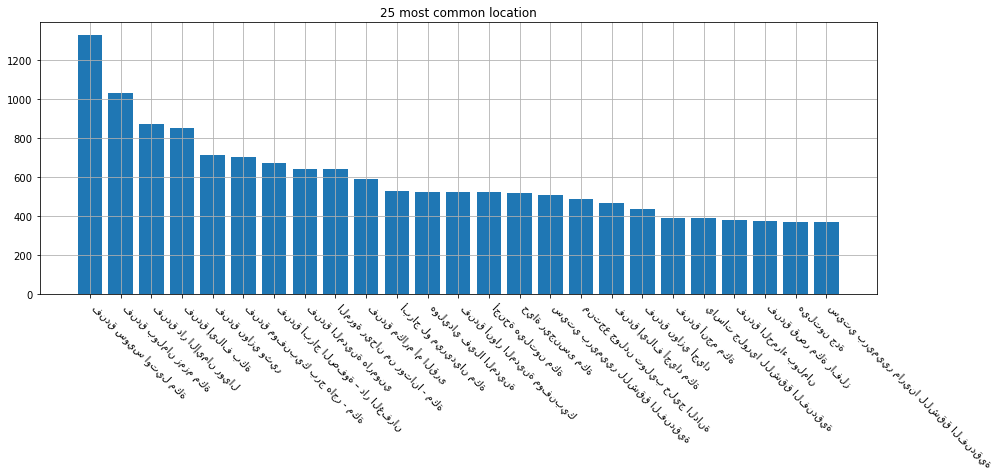

In [41]:
plot_freq_bar(most_25_location.index, most_25_location, '25 most common location', figsize=(15, 5))

In [24]:
# Percentages of ratings in the dataset...
fig = go.Figure(data=[go.Pie(labels=df.Rating, values=df.Rating)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict( line=dict(color='#000000', width=2)))
fig.show()

In [25]:
binray_label = [] 
for rate in df.Rating:
    if rate > 3:
        binray_label.append(1)
    else:
        binray_label.append(0)
df['label'] = binray_label
needed_columns = ['Hotel_name','Review','label']
df = df[needed_columns]
df.sample(n=5, random_state=1000)

,Hotel_name,Review,label
69106,فندق نوازي أجياد,ضعيف. . عدم نظافة المكانو موقع الفندق,0
74456,الأصيل أجياد,ضعيف. . 1.احداثيات الفندق التي على الخريطه غير...,0
26137,فندق كراون بلازا المدينة,“الصراحة وبدون مجاملة من أروع الفنادق من كل ال...,1
10351,فندق كروم الخبر,“انعدام النظافه”. . لايوجد النظافة وجود صراصير...,0
60486,فندق مكة هيلتون,ضعيف جداً. قرب الفندق من الحرم. تعامل ادارة ال...,0


In [28]:
# Ratings distribution in the dataset...
df_rating_count = df[['Hotel_name','label']].groupby(['label']).count().reset_index()
df_rating_count.columns = ['label','count']
fig = go.Figure(data=[go.Bar(x=df_rating_count.label,y=df_rating_count['count'],
                             marker_color=px.colors.qualitative.Plotly)])
fig.update_layout(title_text='Visualizing the Ratings Distribution')